## Predicción de números manuscritos (mnist) utilizando redes neuronales recurrentes

```
Autor     : Etson Ronaldao Rojas Cahuana
Fecha     : 18/13/2023
Lugar     : Cusco, Perú
Proposito : Utilizar redes neuronales recurrentes
            1. SimpleRNN
            2. LSTM
            3. GRU
```

Importar las librerias que se utilizaran

In [259]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from PIL import Image, ImageOps, ImageFilter
from keras.layers import Dropout, Dense, SimpleRNN, CuDNNLSTM, CuDNNGRU
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize


Mostrar version de TensorFlow, Keras y comprobar el uso de GPU local

In [260]:
print("Versions\nKeras:", keras.__version__,"\nTensorFlow: ",tf.__version__)
print("GPU available: ",len(tf.config.experimental.list_physical_devices('GPU')), "\nCuda-built:",tf.test.is_built_with_cuda(), "\nList Tensorflow GPUs: ",tf.config.list_physical_devices('GPU'))
!nvidia-smi --query-gpu=gpu_name --format=csv

Versions
Keras: 2.10.0 
TensorFlow:  2.10.1
GPU available:  1 
Cuda-built: True 
List Tensorflow GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
name
NVIDIA GeForce RTX 3070 Ti Laptop GPU


Importar el dataset mnist obtenido directamente de tensorflow

In [261]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

Mostrar 25 primeros elementos del dataset de mnist con un espacio de color de pixeles de 0 a 255

In [262]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
def mostrarImagenes(imagenes, etiquetas, rgb):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if rgb==True:
            plt.imshow(imagenes[i])
        else:
            plt.imshow(imagenes[i], cmap=plt.cm.binary)
        plt.colorbar()
        plt.xlabel('Label: '+ class_names[etiquetas[i]])
    plt.show()

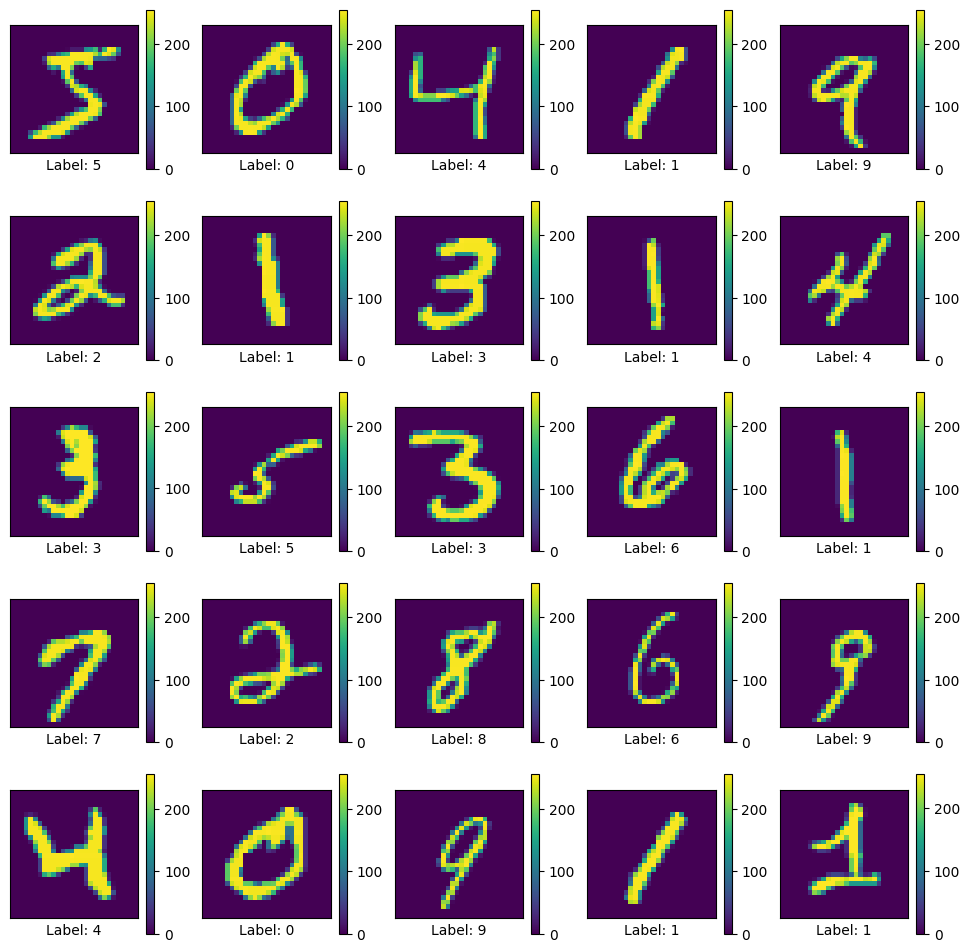

In [263]:
mostrarImagenes(train_images, train_labels, rgb = True)

Transformar los label de cada imagen en un vector del 0 al 9 que contengan ceros y solo exista un 1 indicando su posicion

In [264]:
translation_dict = {
    '0':[1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
    '1':[0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,],
    '2':[0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,],
    '3':[0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,],
    '4':[0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,],
    '5':[0.,0.,0.,0.,0.,1.,0.,0.,0.,0.,],
    '6':[0.,0.,0.,0.,0.,0.,1.,0.,0.,0.,],
    '7':[0.,0.,0.,0.,0.,0.,0.,1.,0.,0.,],
    '8':[0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,],
    '9':[0.,0.,0.,0.,0.,0.,0.,0.,1.,0.,],
    '0':[0.,0.,0.,0.,0.,0.,0.,0.,0.,1.,]
}
y_train = np.empty((train_labels.shape[0], 10), dtype=np.float32)
i = 0
for number in train_labels:
    y_train[i]=translation_dict[str(number)]
    i+=1

y_test = np.empty((test_labels.shape[0], 10), dtype=np.float32)
i = 0
for number in test_labels:
    y_test[i]=translation_dict[str(number)]
    i+=1

Normalizar las imagenes convirtiendolos en una imagen con pixeles entre 0 y 1

In [265]:
train_images = train_images/255.0
test_images = test_images/255.0

Mostrar 25 primeros elementos del dataset de mnist normalizado reduciendo el espacio de color de 0 a 1

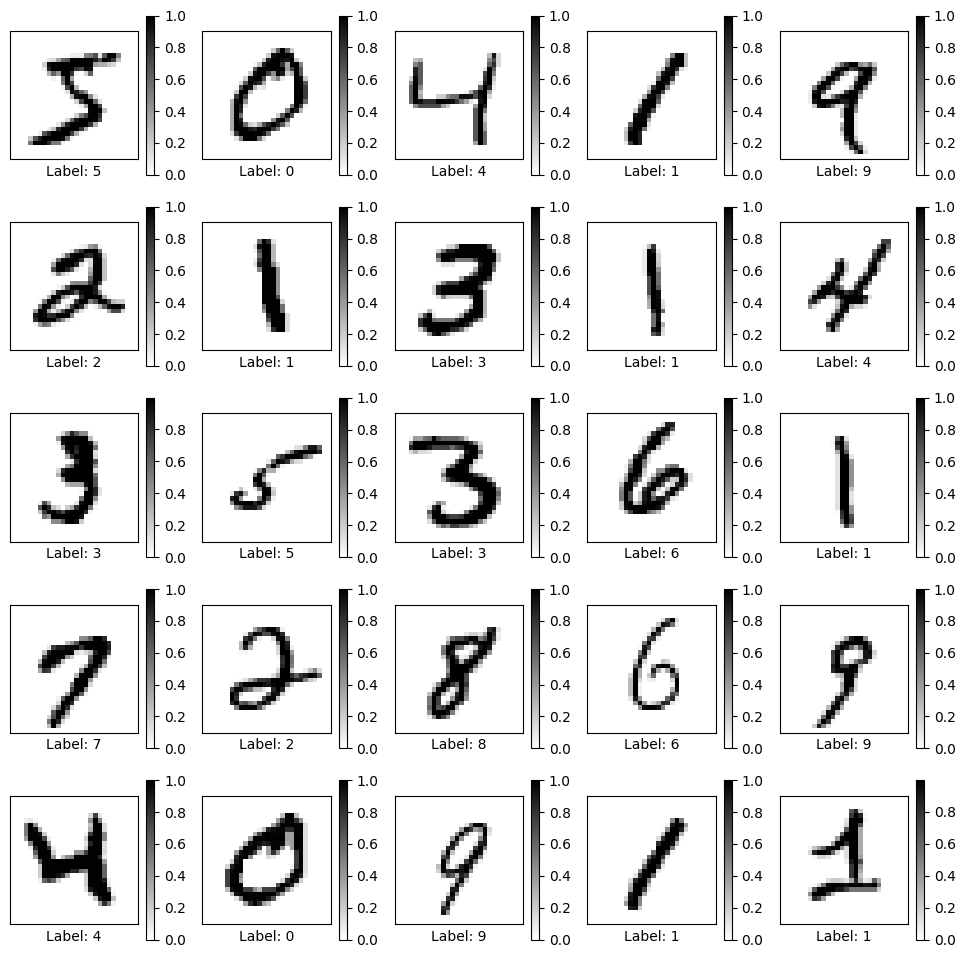

In [266]:
mostrarImagenes(train_images, train_labels, rgb=False)

Preparar las etiquetas de las imagenes para el entrenamiento

In [267]:
train_labels, test_labels = y_train, y_test

### Crear una RNN simple

In [268]:
from keras.utils import to_categorical
modelSimpleRNN = Sequential()
modelSimpleRNN.add(SimpleRNN(128,activation='relu', input_shape = (train_images.shape[1:]),return_sequences=True))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(SimpleRNN(128,activation='relu'))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(Dense(64,activation='relu'))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(Dense(10,activation='softmax'))
modelSimpleRNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],)
modelSimpleRNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 28, 128)           20096     
                                                                 
 dropout_9 (Dropout)         (None, 28, 128)           0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 10)               

Entrenar el modelo de RNN para 3 epocas

In [269]:
histSimpleRNN = modelSimpleRNN.fit(train_images, train_labels, epochs=3, batch_size=32, validation_data=(test_images,test_labels))

Epoch 1/3
1875/1875 [==============================] - 77s 40ms/step - loss: 0.4873 - accuracy: 0.8428 - val_loss: 0.1465 - val_accuracy: 0.9585
Epoch 2/3
1875/1875 [==============================] - 93s 49ms/step - loss: 0.1928 - accuracy: 0.9486 - val_loss: 0.1245 - val_accuracy: 0.9675
Epoch 3/3
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1535 - accuracy: 0.9602 - val_loss: 0.1013 - val_accuracy: 0.9688


Mostrar grafico de precisión y el valor de precisión.

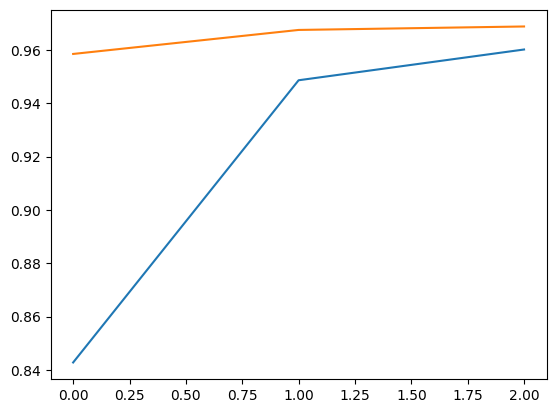

In [270]:
plt.plot(histSimpleRNN.history['accuracy'])
plt.plot(histSimpleRNN.history['val_accuracy'])
plt.show()

### Crear un modelo LSTM utilizando CuDNNLSTM

In [271]:
model_CuDNNLSTM = Sequential()
#No necesita funcion de activación ya que esta tiene la tangente hiperbolica dentro
model_CuDNNLSTM.add(CuDNNLSTM(128, input_shape = (train_images.shape[1:]),return_sequences=True))
model_CuDNNLSTM.add(Dropout(0.2))
model_CuDNNLSTM.add(CuDNNLSTM(128))
model_CuDNNLSTM.add(Dropout(0.2))
model_CuDNNLSTM.add(Dense(64,activation='relu'))
model_CuDNNLSTM.add(Dropout(0.2))
model_CuDNNLSTM.add(Dense(10,activation='softmax'))
model_CuDNNLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],)
model_CuDNNLSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 28, 128)           80896     
                                                                 
 dropout_12 (Dropout)        (None, 28, 128)           0         
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 10)               

Entrenar el modelo de LSTM para 3 epocas

In [272]:
hist_CuDNNLSTM = model_CuDNNLSTM.fit(train_images, train_labels, epochs=3, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/3
1875/1875 [==============================] - 17s 8ms/step - loss: 0.3758 - accuracy: 0.8816 - val_loss: 0.1140 - val_accuracy: 0.9650
Epoch 2/3
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1088 - accuracy: 0.9691 - val_loss: 0.0721 - val_accuracy: 0.9788
Epoch 3/3
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0766 - accuracy: 0.9785 - val_loss: 0.0591 - val_accuracy: 0.9823


Mostrar grafico de precisión y el valor de precisión.

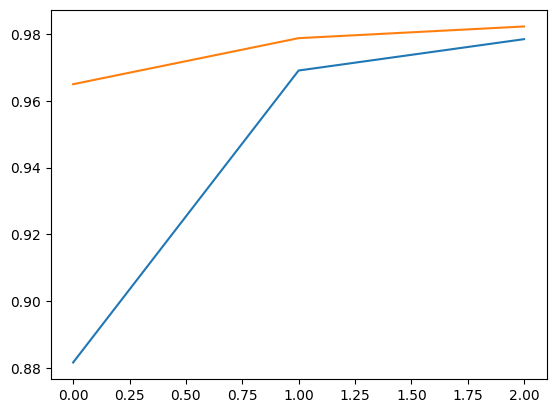

In [273]:
plt.plot(hist_CuDNNLSTM.history['accuracy'])
plt.plot(hist_CuDNNLSTM.history['val_accuracy'])
plt.show()

### Crear una red GRU utilizando CuDNNGRU

In [274]:
model_CuDNNGRU = Sequential()
#No necesita funcion de activación ya que esta tiene la tangente hiperbolica dentro
model_CuDNNGRU.add(CuDNNGRU(128, input_shape = (train_images.shape[1:]),return_sequences=True))
model_CuDNNGRU.add(Dropout(0.2))
model_CuDNNGRU.add(CuDNNGRU(128))
model_CuDNNGRU.add(Dropout(0.2))
model_CuDNNGRU.add(Dense(64,activation='relu'))
model_CuDNNGRU.add(Dropout(0.2))
model_CuDNNGRU.add(Dense(10,activation='softmax'))
model_CuDNNGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],)
model_CuDNNGRU.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnngru_2 (CuDNNGRU)      (None, 28, 128)           60672     
                                                                 
 dropout_15 (Dropout)        (None, 28, 128)           0         
                                                                 
 cu_dnngru_3 (CuDNNGRU)      (None, 128)               99072     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)               

Entrenar el modelo de GRU para 3 epocas

In [275]:
hist_CuDNNGRU = model_CuDNNGRU.fit(train_images, train_labels, epochs=3, batch_size=32, validation_data=(test_images,test_labels))

Epoch 1/3
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3338 - accuracy: 0.8913 - val_loss: 0.1007 - val_accuracy: 0.9689
Epoch 2/3
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0920 - accuracy: 0.9728 - val_loss: 0.0556 - val_accuracy: 0.9852
Epoch 3/3
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0646 - accuracy: 0.9816 - val_loss: 0.0492 - val_accuracy: 0.9858


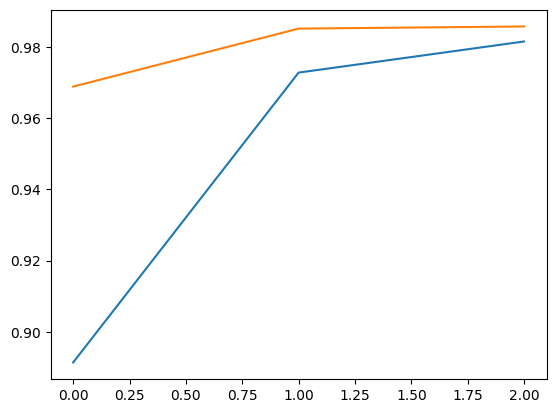

In [276]:
plt.plot(hist_CuDNNGRU.history['accuracy'])
plt.plot(hist_CuDNNGRU.history['val_accuracy'])
plt.show()

Evaluar con los modelos entrenados y mostrar su nivel de precision

In [277]:
print('Simple RNN')
test_loss, test_acc = modelSimpleRNN.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', test_acc)
print('\nLSTM')
test_loss, test_acc = model_CuDNNLSTM.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', test_acc)
print('\nGRU')
test_loss, test_acc = model_CuDNNGRU.evaluate(test_images,  test_labels, verbose=2)
print('Test accuracy:', test_acc)

Simple RNN
313/313 - 3s - loss: 0.1013 - accuracy: 0.9688 - 3s/epoch - 8ms/step
Test accuracy: 0.9688000082969666

LSTM
313/313 - 1s - loss: 0.0591 - accuracy: 0.9823 - 1s/epoch - 4ms/step
Test accuracy: 0.9822999835014343

GRU
313/313 - 1s - loss: 0.0492 - accuracy: 0.9858 - 1s/epoch - 4ms/step
Test accuracy: 0.98580002784729


# Predicciones

Funciones para mostrar predicciones con imagenes

In [279]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def MostrarPredicciones(modeloPrediccion):
  num_rows = 5
  num_cols = 4
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, modeloPrediccion[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, modeloPrediccion[i], test_labels)
  plt.tight_layout()
  plt.show()

Realizar la prediccion con los datos de test

In [280]:
predictionsSimpleRNN = modelSimpleRNN.predict(test_images)
predictionsLSTM = model_CuDNNLSTM.predict(test_images)
predictionsGRU = model_CuDNNGRU.predict(test_images)

313/313 [==============================] - 1s 3ms/step


Convertir a un vector las etiquetas de los datos de test para predecir.

In [281]:
labels = []
for elemento in test_labels: labels.append(np.where(elemento == 1)[0][0])
test_labels = labels

Predecir una imagen en especifico del conjunto de imagenes de test, en el siguiente ejemplo se utilizó el dato numnero 1568.

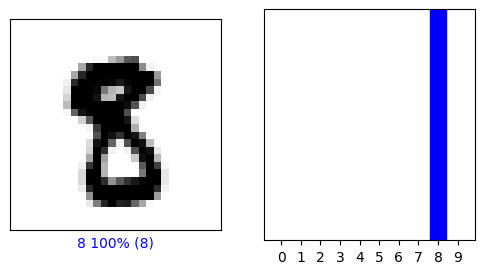

In [282]:
i = 1568
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictionsSimpleRNN[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictionsSimpleRNN[i],  test_labels)
plt.show()

Mostrar las 20 primeras predicciones del modelo **RNN Simple**.

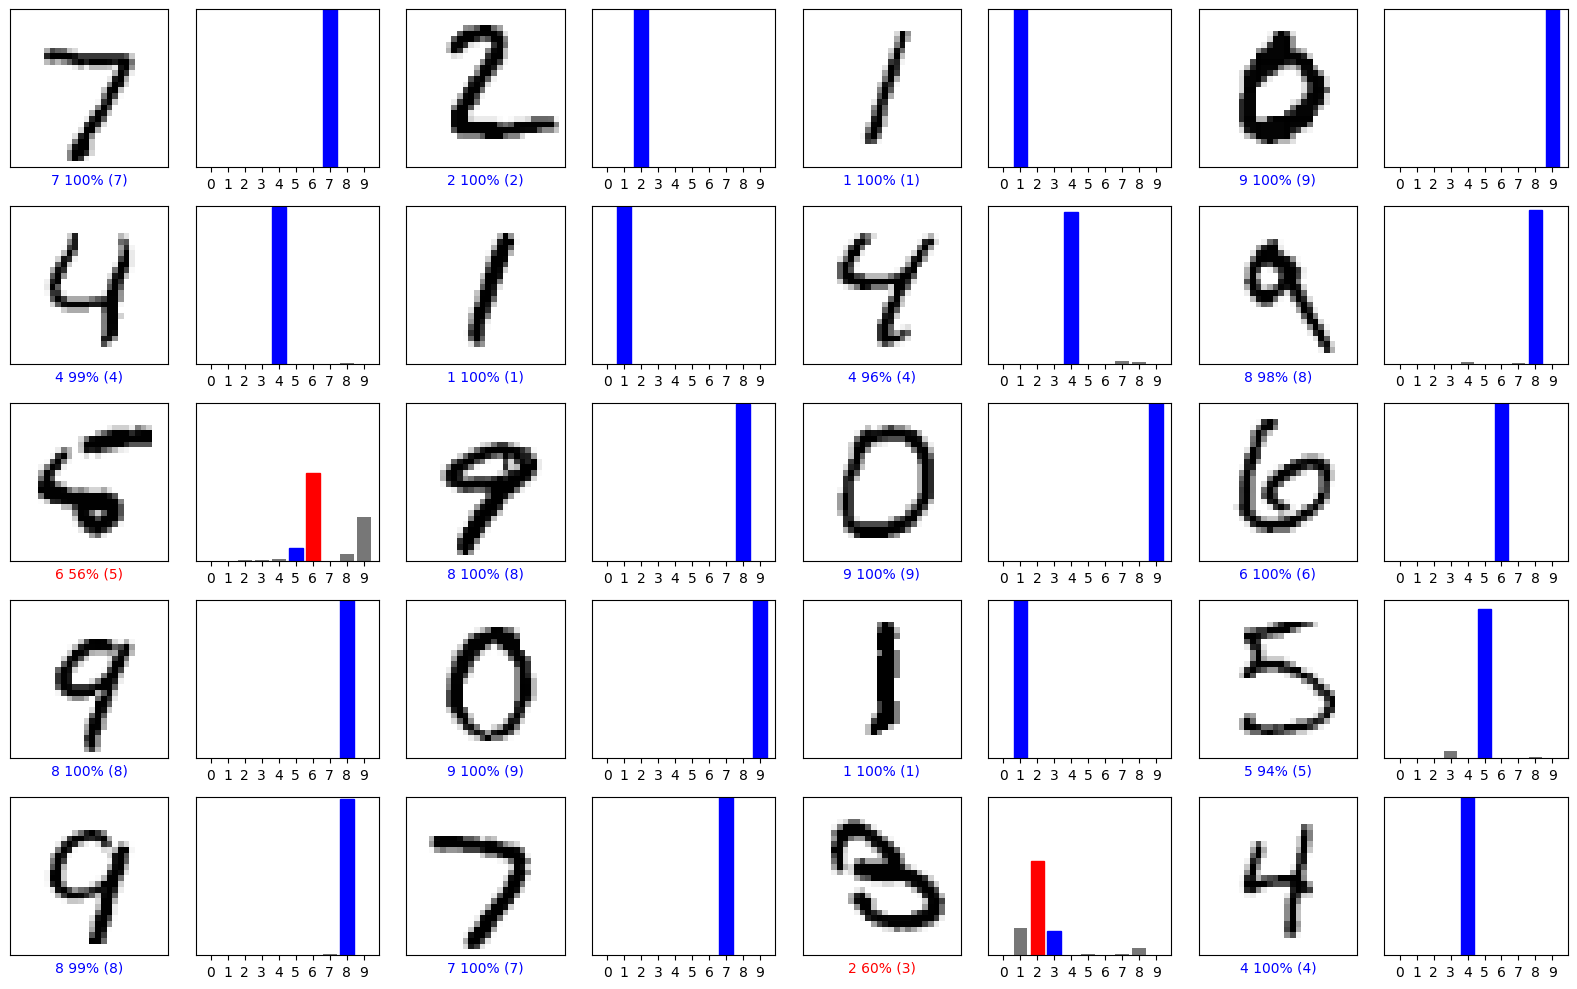

In [283]:
MostrarPredicciones(predictionsSimpleRNN)

Mostrar las 20 primeras predicciones del modelo **LSTM**.

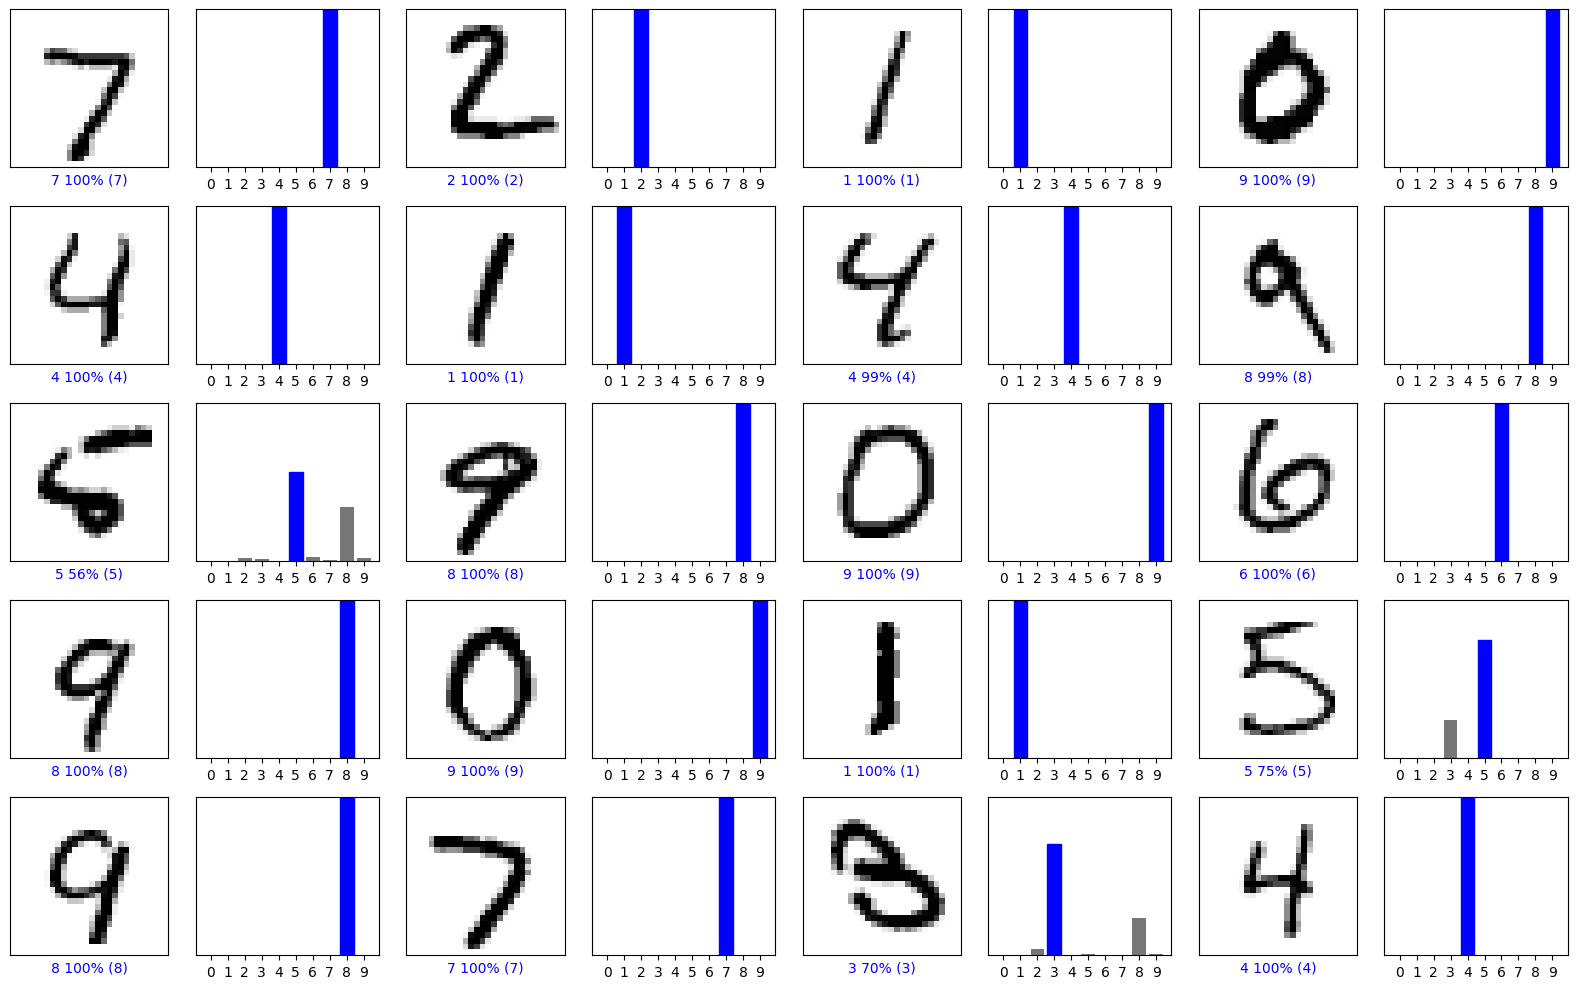

In [284]:
MostrarPredicciones(predictionsLSTM)

Mostrar las 20 primeras predicciones del modelo **GRU**.

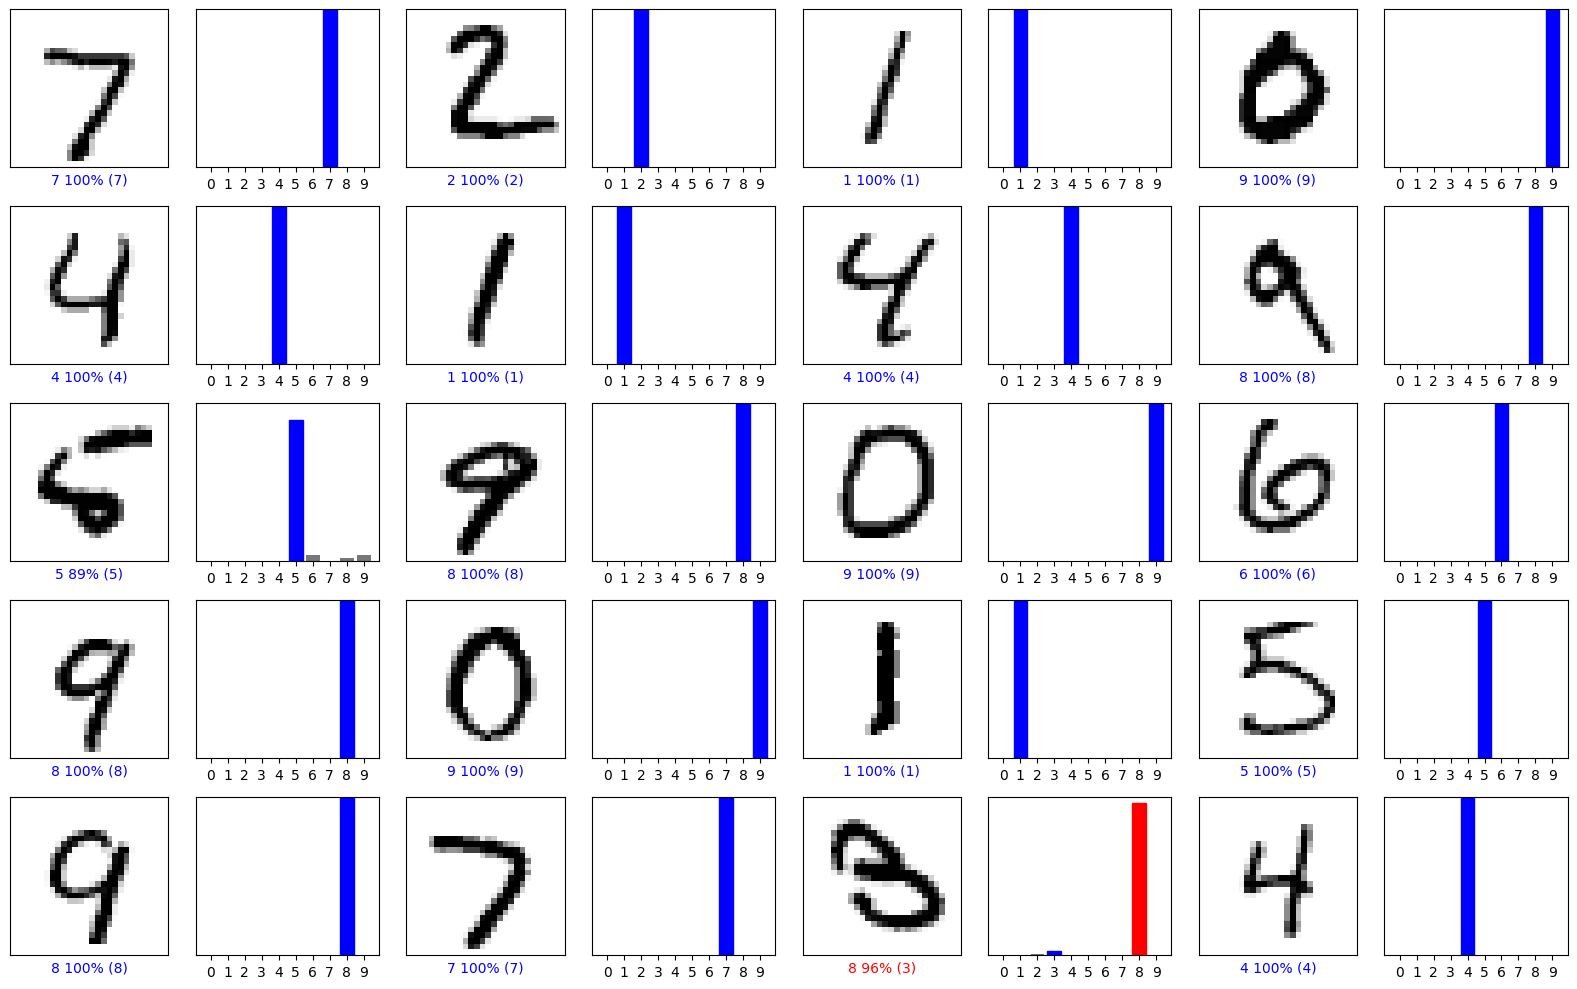

In [285]:
MostrarPredicciones(predictionsGRU)

Predicciones con datos externos

In [295]:
def binarizar(pixel):
    #Umbral 128
    if pixel < 128:
        return 0
    else:
        return 255
def predecir_imagen_externa(path_img):
    # Cargar imagen
    img = load_img(path_img, color_mode='rgb') #, target_size=(28,28))

    # Crear una figura con 1x5 subfiguras
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(18, 3))
    fig.subplots_adjust(hspace=0.4, top=0.80)
    fig.suptitle("Redes Neuronales Recurrentes", fontsize=15, color='red')

    #Mostrar la imagen de entrada
    im1 = axs[0].imshow(img)
    axs[0].set_title('Imagen Original')

    #Cambiar a tamaño 28 x 28 con antialiasing
    img = img.resize((28, 28), Image.Resampling.LANCZOS)

    #Invertir colores y convertir a escala de grises
    img = ImageOps.invert(img)
    img = ImageOps.grayscale(img)

    # Aplicar el filtro de binarización a la imagen y generar un desenfoque gausiano y reducir la gama de colores a 0-1
    img = img.point(binarizar)
    img = img.filter(ImageFilter.GaussianBlur(0.40))
    img_array = img_to_array(img)/255

    #Mostrar la imagen preprocesada
    axs[1].set_title('Imagen procesada')
    im2 = axs[1].imshow(img_array, cmap=plt.cm.binary)
    img_array = np.reshape(img_array, (1,28,28))

    # Hacer la predicción para RNN
    predictions = modelSimpleRNN.predict(np.transpose(img_array, (0, 1, 2)), verbose='none')
    predicted_class = np.argmax(predictions[0])
    axs[2].bar(class_names, predictions[0])
    axs[2].set_title(f'Predicción RNN Simple: {class_names[predicted_class]}')

    # Hacer la predicción para LSTM
    predictions = model_CuDNNLSTM.predict(np.transpose(img_array, (0, 1, 2)), verbose='none')
    predicted_class = np.argmax(predictions[0])
    axs[3].bar(class_names, predictions[0])
    axs[3].set_title(f'Predicción LSTM: {class_names[predicted_class]}')

    # Hacer la predicción para GRU
    predictions = model_CuDNNGRU.predict(np.transpose(img_array, (0, 1, 2)), verbose='none')
    predicted_class = np.argmax(predictions[0])
    axs[4].bar(class_names, predictions[0])
    axs[4].set_title(f'Predicción GRU: {class_names[predicted_class]}')

    # Agregar barra de color
    fig.colorbar(im1, ax=axs[0])
    fig.colorbar(im2, ax=axs[1])
    plt.show()

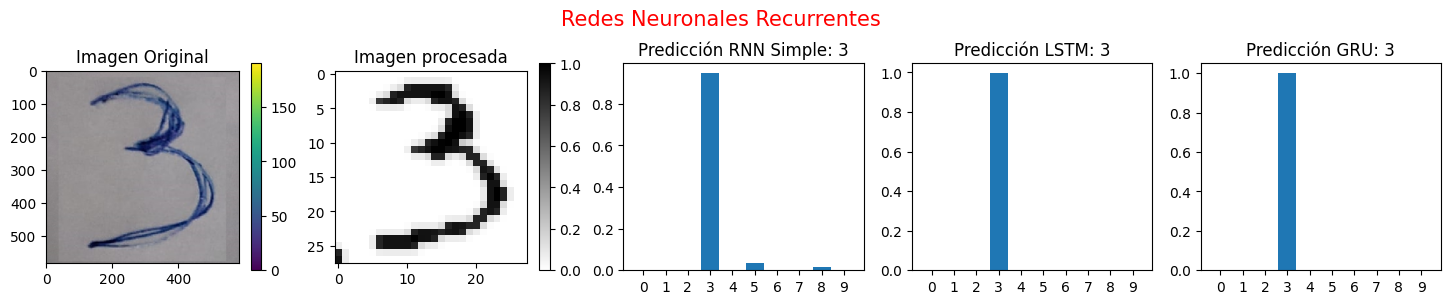

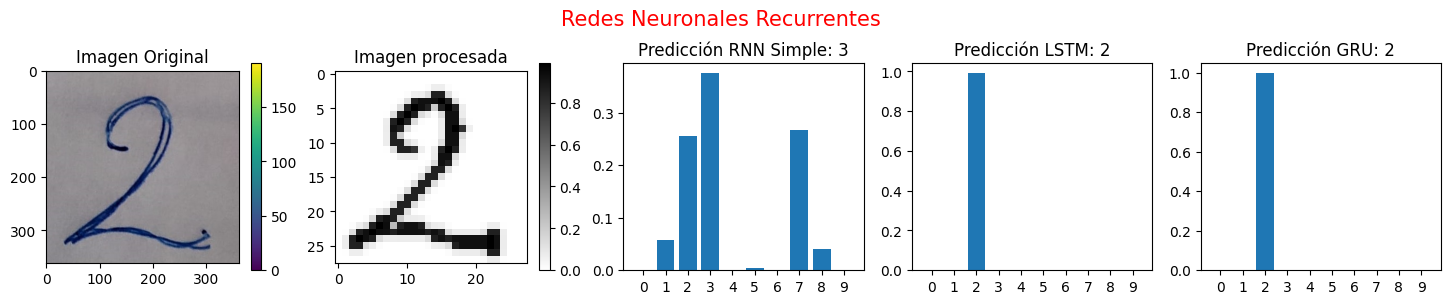

In [296]:
predecir_imagen_externa('content/3.jpg')
predecir_imagen_externa('content/2.jpg')

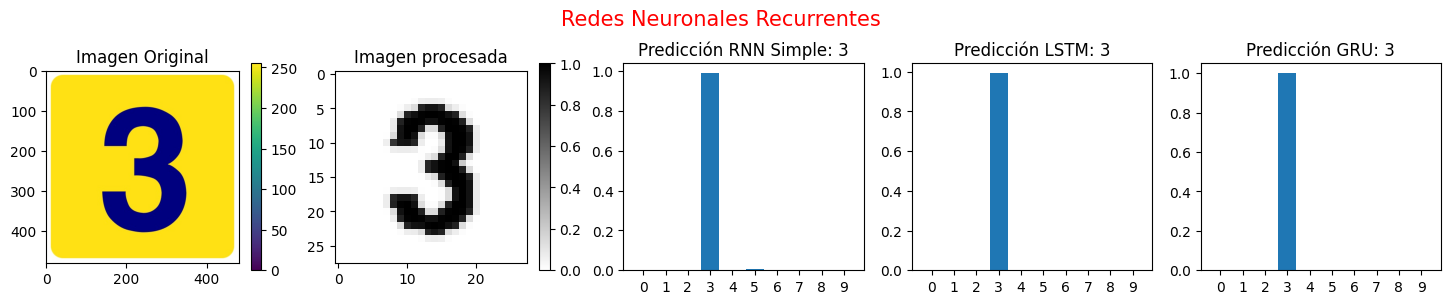

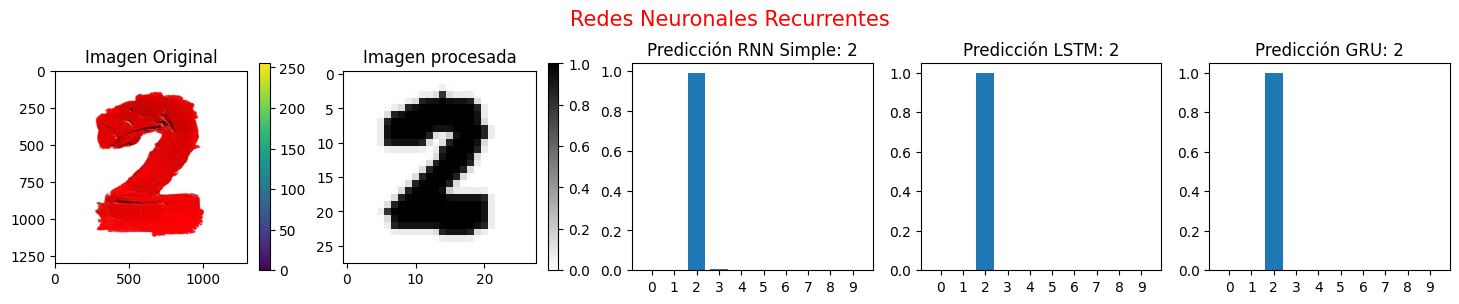

In [297]:
predecir_imagen_externa('content/numero_3.jpg')
predecir_imagen_externa('content/2_.jpg')

Guardar modelos

In [33]:
modelSimpleRNN.save('content/model_SimpleRNN_MNIST.h5')
model_CuDNNLSTM.save('content/model_LSTM_MNIST.h5')
model_CuDNNGRU.save('content/model_LSTM_GRU.h5')